In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
import sqlite3 as db
import matplotlib.pyplot as pp

In [2]:
github_userName = 'Tanag3r'
ebird_token = 'j6c7l80ga2ib'
db_name = 'trailheadDirectBirds_sous.db'

In [3]:
##connect to database
def connectDB():
    try:
        cnx = db.connect(db_name)
    except Exception as cnxError:
        raise UserWarning(f'Unable to connect to database due to: {cnxError}')
    return cnx

In [74]:
def weeklyAbundance():
    cnx = connectDB()
    try:
        ObsDataset = pd.read_sql('SELECT comName,locId,obsDt,howMany,subId FROM historicObservations WHERE comName == "Canada Jay";',con=cnx,parse_dates=['obsDt']) #Canada Jay filter is for testing purposes only
        ObsDataset['obsDt_week'] = ObsDataset['obsDt'].dt.isocalendar().week
        #group up data
        ObsDataset = ObsDataset.groupby(['comName','locId','obsDt_week'])['howMany'].median()
        ObsDataset = pd.DataFrame(ObsDataset)
        ObsDataset['relativeAbundance'] = (ObsDataset['howMany']/ObsDataset['howMany'].mean())/max(ObsDataset['howMany']/ObsDataset['howMany'].mean())
        ObsDataset.sort_values(by=['comName','obsDt_week'],ascending=True,inplace=True)   #not needed
        ObsDataset.reset_index(inplace=True)   #not needed
    except Exception as calcEx:
        raise UserWarning(calcEx)
    return ObsDataset

In [75]:
trx = weeklyAbundance()
trx

,comName,locId,obsDt_week,howMany,relativeAbundance
0,Canada Jay,L8312096,1,1.0,0.125
1,Canada Jay,L12172834,10,6.0,0.750
2,Canada Jay,L12172834,11,2.0,0.250
3,Canada Jay,L10129014,13,4.0,0.500
4,Canada Jay,L12172834,40,7.0,0.875
5,Canada Jay,L12172834,49,2.0,0.250
6,Canada Jay,L8312096,49,1.0,0.125
7,Canada Jay,L12172834,52,4.0,0.500
8,Canada Jay,L424117,52,3.0,0.375
9,Canada Jay,L8312096,52,1.0,0.125


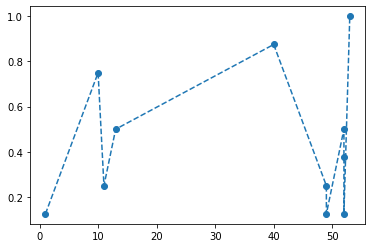

In [76]:
##TODO #67 interpolate sighting values into the test Canada Jay dataset

In [ ]:
##TODO #66 split out birds into quartiles based on the number of observations available and the YOY frequency. Results will determine the strength of forecasting required

In [ ]:
            for locId in habitatAdundance.itertuples():
                f = lambda x: locId.relativeAbundance*x
                lao = habitatAdundance.drop(['comName','locId','obsDt_week','howMany','relativeAbundance','locName','cleanPixels','Pixels'],axis=1)
                lao.applymap(f)
                lao = lao.apply(np.mean,axis=0)
                lao['comName'] = locId.comName
                listy.append(lao.transpose())

In [222]:
##TODO #64 using the relative abundance value from weeklyAbundance(), write a function that returns FAO land coverage preference
##TODO #68 add seasons to relative abundance function, then add in a loop over each season in the function seasonalHabitatPreference
def seasonalHabitatPref():
    cnx = connectDB()
    try:
        wklyAbd = weeklyAbundance()
        hotspotLAO = pd.read_sql('SELECT * FROM FAO_by_locId',con=cnx)
        habitatAdundance = pd.merge(left=wklyAbd,right=hotspotLAO,left_on='locId',right_on='locId',how='left')
        #start season loop here
        #TODO #69 multiply land coverage by relative abundance before computing seasonal habitat preferences
        listy = []
        for locId in habitatAdundance.itertuples():
            query = f'SELECT waterBodies,evergreenNeedleleafForest,evergreenBroadleafForests,openForests,mixedBroadleafandNeedleleafForests,sparseForests,denseHerbaceous,sparseHerbaceous FROM FAO_by_locId WHERE FAO_by_locId.locId = "{locId.locId}"'
            lx = pd.read_sql(query,con=cnx)
            lx.map(lambda x: x+1,na_action='ignore')
            listy.append(lx)
        results = pd.DataFrame()
        results = pd.concat(listy,ignore_index=True)
        #do math
        #habitatAdundance['evergreenNeedleleafForest'] = habitatAdundance['evergreenNeedleleafForest']*habitatAdundance['relativeAbundance']
    except Exception as prefExc:
        raise UserWarning(prefExc)
    return results

In [223]:
adun = seasonalHabitatPref()
adun


,waterBodies,evergreenNeedleleafForest,evergreenBroadleafForests,openForests,mixedBroadleafandNeedleleafForests,sparseForests,denseHerbaceous,sparseHerbaceous
0,None,0.13,NaN,NaN,0.88,NaN,None,None
1,None,1.00,NaN,NaN,NaN,NaN,None,None
2,None,1.00,NaN,NaN,NaN,NaN,None,None
3,None,0.22,NaN,0.19,NaN,0.59,None,None
4,None,1.00,NaN,NaN,NaN,NaN,None,None
5,None,1.00,NaN,NaN,NaN,NaN,None,None
6,None,0.13,NaN,NaN,0.88,NaN,None,None
7,None,1.00,NaN,NaN,NaN,NaN,None,None
8,None,0.15,0.13,NaN,0.81,NaN,None,None
9,None,0.13,NaN,NaN,0.88,NaN,None,None


In [ ]:
wklyAbd = weeklyAbundance()
cnx = connectDB()
listy = []
for locId in wklyAbd.itertuples():
    query = f'SELECT waterBodies,evergreenNeedleleafForest,evergreenBroadleafForests,openForests,mixedBroadleafandNeedleleafForests,sparseForests,denseHerbaceous,sparseHerbaceous FROM FAO_by_locId WHERE FAO_by_locId.locId = "{locId.locId}"'
    lx = pd.read_sql(query,con=cnx)
    lx.applymap(lambda x: x+1,na_action='ignore')
    listy.append(lx)
results = pd.DataFrame()
results = pd.concat(listy,ignore_index=True)

In [ ]:
##TODO #65 using historic habitat preference data, forecast the seasonal habitat preference for each species of bird